In [1]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import scipy.stats
import sklearn
import xgboost
import shap

# データを生成するためのクラスや関数を作成
class FixableDataFrame(pd.DataFrame):
    """ Helper class for manipulating generative models.
    """
    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super(FixableDataFrame, self).__init__(*args, **kwargs)
    def __setitem__(self, key, value):
        out = super(FixableDataFrame, self).__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super(FixableDataFrame, self).__setitem__(key, self.__dict__["__fixed_var_dictionary"][key])
        return out

def generator(n, fixed={}, seed=0):
    """ The generative model for our subscriber retention example.
    """
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)

    # 訪問販売の回数
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # 交流回数
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # 消費者が住む地域の経済状況
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # 最終更新時期
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # プロダクトのニーズ（未観測）
    X["Product need"] = (X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,)))

    # 割引額
    X["Discount"] = ((1-scipy.special.expit(X["Product need"])) * 0.5 + 0.5 * np.random.uniform(0, 1, size=(n,))) / 2

    # ユーザーの利用頻度
    X["Monthly usage"] = scipy.special.expit(X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,)))

    # 広告費用
    X["Ad spend"] = X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,)) + (X["Last upgrade"] < 1) + (X["Last upgrade"] < 2)

    # ユーザーのバグ遭遇回数（未観測）
    X["Bugs faced"] = np.array([np.random.poisson(v*2) for v in X["Monthly usage"]])

    # ユーザーのバグ報告回数
    X["Bugs reported"] = (X["Bugs faced"] * scipy.special.expit(X["Product need"])).round()

    # ユーザーがサブスクを更新する確率
    X["Did renew"] = scipy.special.expit(7 * (
          0.18 * X["Product need"] \
        + 0.08 * X["Monthly usage"] \
        + 0.1 * X["Economy"] \
        + 0.05 * X["Discount"] \
        + 0.05 * np.random.normal(0, 1, size=(n,)) \
        + 0.05 * (1 - X['Bugs faced'] / 20) \
        + 0.005 * X["Sales calls"] \
        + 0.015 * X["Interactions"] \
        + 0.1 / (X["Last upgrade"]/4 + 0.25)
        + X["Ad spend"] * 0.0 - 0.45
    ))
    # ユーザーがサブスクを更新したかどうか（更新していたら1）
    X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X

def user_retention_dataset():
    """ The observed data for model training.
    """
    n = 10000
    X_full = generator(n)
    y = X_full["Did renew"]
    X = X_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y

def fit_xgboost(X, y):
    """ Train an XGBoost model with early stopping.
    """
    X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y)
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dtest = xgboost.DMatrix(X_test, label=y_test)
    model = xgboost.train(
        { "eta": 0.001, "subsample": 0.5, "max_depth": 2, "objective": "reg:logistic"}, dtrain, num_boost_round=200000,
        evals=((dtest, "test"),), early_stopping_rounds=20, verbose_eval=False
    )
    return model

# データを格納
X, y = user_retention_dataset()

# 値の確認
display(pd.DataFrame(X).head())
display(pd.DataFrame(y).head())

/Users/tamurashuntarou/CML/code/master_shap/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Sales calls,Interactions,Economy,Last upgrade,Discount,Monthly usage,Ad spend,Bugs reported
0,2.0,2.0,0.719054,17.036984,0.283774,0.825265,0.803090,1.0
1,3.0,3.0,0.188017,13.464172,0.059483,0.287509,0.275391,0.0
2,2.0,2.0,0.387437,1.631930,0.167273,0.433489,1.396768,1.0
3,2.0,2.0,0.866165,7.710981,0.330207,0.235349,0.218303,0.0
4,2.0,2.0,0.585444,6.391478,0.299390,0.824211,0.815360,1.0


,Did renew
0,0
1,1
2,0
3,0
4,0


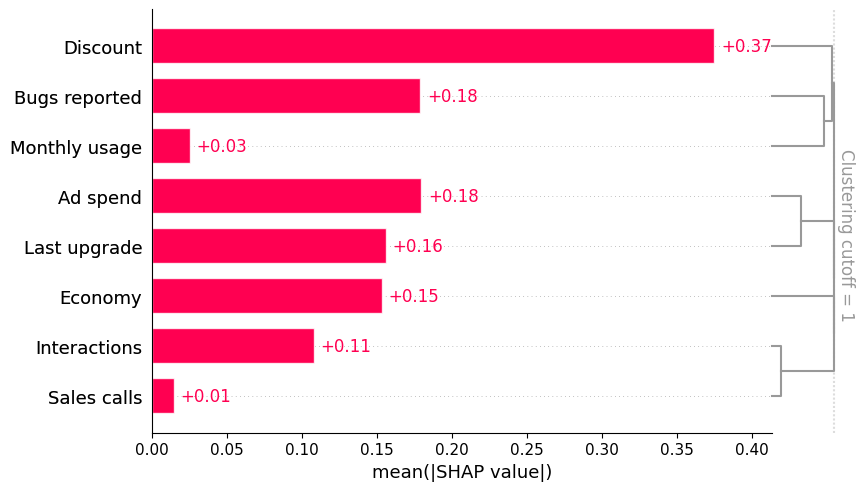

In [2]:
# 予測モデルを学習
model = fit_xgboost(X, y)

# SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

clust = shap.utils.hclust(X, y, linkage="complete")

# 予測モデルにおける特徴量の重要度をプロット
shap.plots.bar(shap_values, clustering=clust, clustering_cutoff=1)

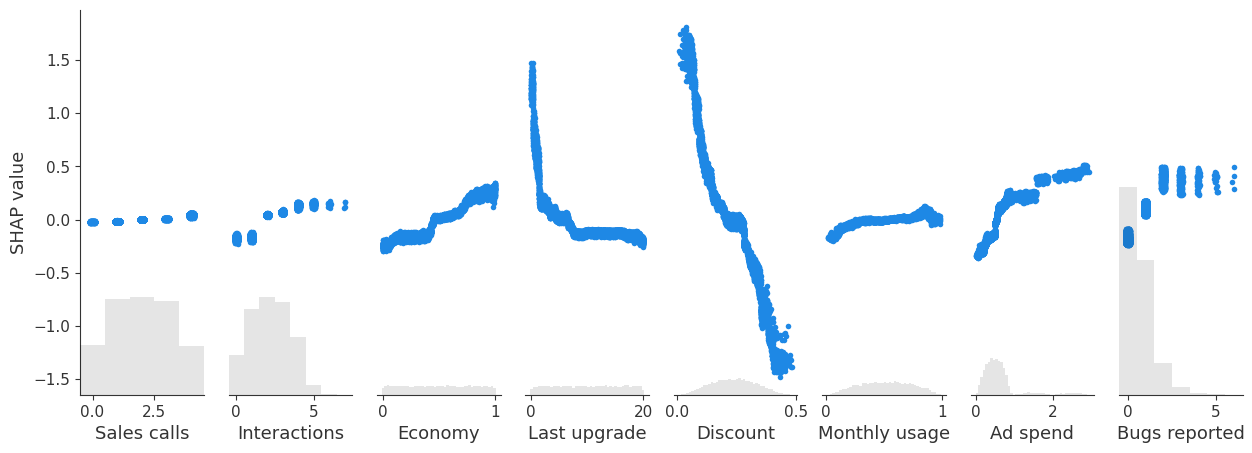

In [3]:
# 散布図を描画
shap.plots.scatter(shap_values)

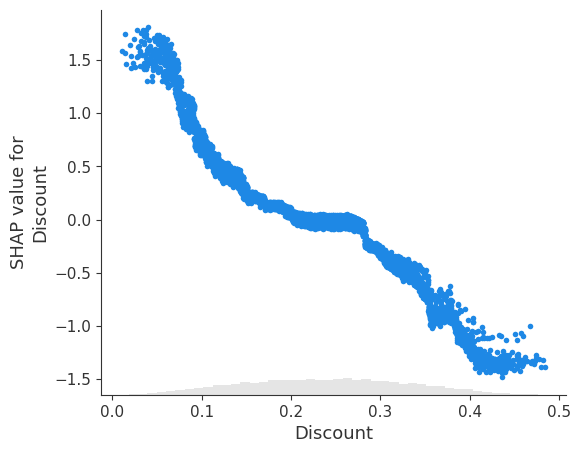

In [4]:
# 散布図を描画
shap.plots.scatter(shap_values[:, "Discount"])